Step 1: Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene, ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from semopy import Model, calc_stats
import warnings
warnings.filterwarnings('ignore')


Step 2: Preprocess data

Step 2.1: Import data and delete unused columns

In [8]:

# read data
df = pd.read_csv("zone.csv")
# format columns
df.columns = ['Datetime','Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows',
              'Zone1','Zone2','Zone3']
# change Datetime to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.dropna(subset=['Datetime']).sort_values('Datetime')
df = df.drop([
   'GeneralDiffuseFlows','DiffuseFlows','Zone2','Zone3'
], axis=1)

Step 2.2: Resample data to hour

In [9]:
# Merge data following hour
df_hour = (
    df.set_index('Datetime')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)
print(f"The initial columns: {len(df)} → After merging followed by hour: {len(df_hour)}")


The initial columns: 52416 → After merging followed by hour: 8736


Step 2.3: View data

In [10]:
df_hour.head()

,Datetime,Temperature,Humidity,WindSpeed,Zone1
0,2017-01-01 00:00:00,6.196833,75.066667,0.081833,29197.974683
1,2017-01-01 01:00:00,5.548833,77.583333,0.082000,24657.215190
2,2017-01-01 02:00:00,5.054333,78.933333,0.082333,22083.037973
3,2017-01-01 03:00:00,5.004333,77.083333,0.082833,20811.139240
4,2017-01-01 04:00:00,5.097667,74.050000,0.082333,20475.949367


Step 3

Step 3.1 Descriptive statistics

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
Temperature,8736.0,18.810,5.808,3.602,14.404,18.759,22.867,39.695,30.875,0.197,-0.309
Humidity,8736.0,68.260,15.476,12.710,58.325,69.816,81.350,94.750,22.672,-0.621,-0.125
Zone1,8736.0,32344.971,7068.920,14329.114,26292.952,32342.303,37318.002,51844.262,21.855,0.214,-0.776


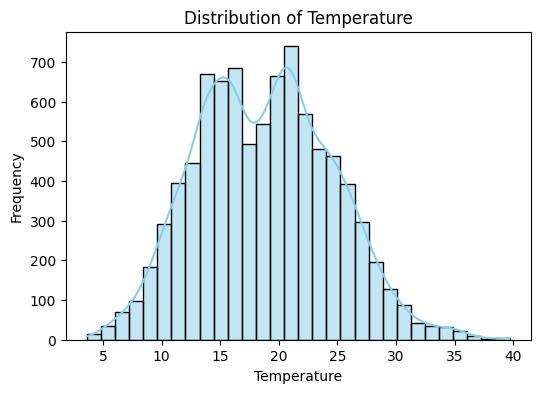

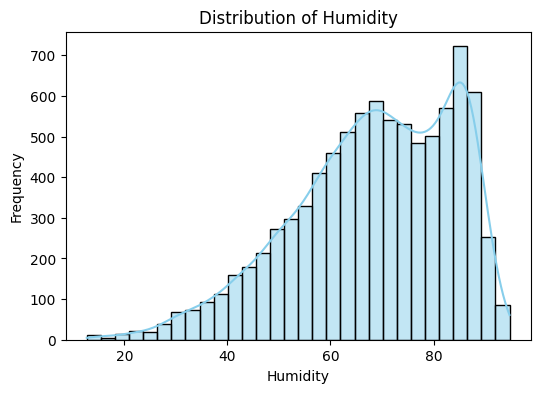

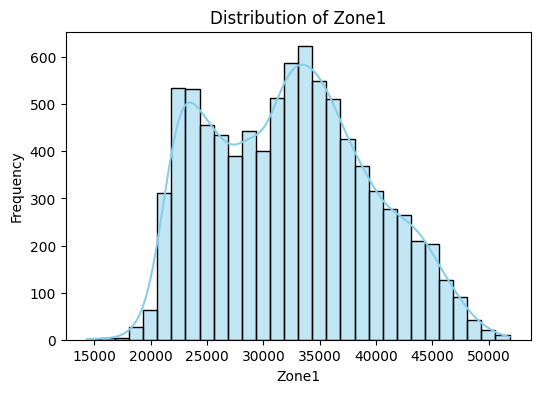

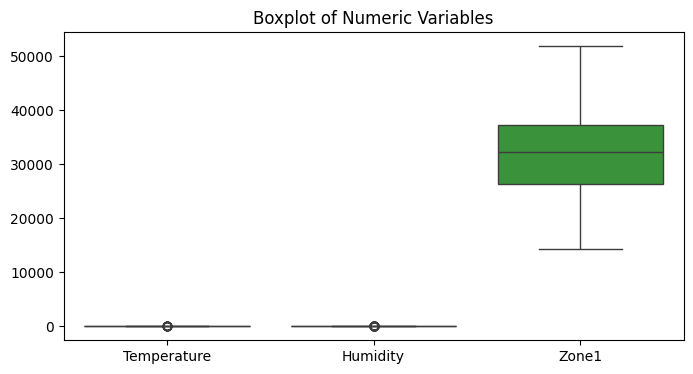

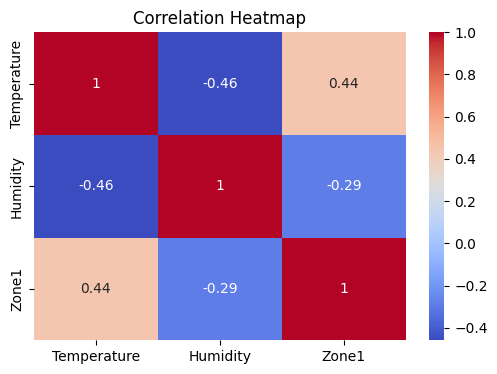

In [11]:
import numpy as np
from scipy.stats import skew, kurtosis
# Choose numeric columns
num_cols = ['Temperature', 'Humidity', 'Zone1']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create empty DataFrame to store stats
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round stats for better readability
stats = stats.astype(float).round(3)

# Show statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Draw visualizations
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(data=df_hour[num_cols])
plt.title("Boxplot of Numeric Variables")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df_hour[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()